In [145]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

np.random.seed(29)

%run ./DiffusionLunarKF.ipynb
%run ./CentralizedLunarKF.ipynb
%run ./FilterComparison.ipynb

In [146]:
C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
C_ckf = 0.2*np.ones((5,5))
D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])
D_ckf = 3*np.ones((5,5))
n = len(C)

true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
# true_drifts = np.array([[0 for _ in range(n)]]).T

F = np.array([[1,dt],[0,1]])
F_full = np.kron(np.eye(n),F)

def get_station_truth(x,id):
    return np.array([[x[2*id][0]],[x[2*id+1][0]]])

x = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))

# random initial estimates for each node

x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]


P = [100*np.copy(R(1)) for _ in range(n)]

stations = [Station(i) for i in range(n)]
stations_ckf = [Station(i) for i in range(n)]
filter_initialize(stations,D,x0,P)

filter_initialize(stations_ckf,D_ckf,x0,P)


In [147]:
iterations = 200

# num_msmts = np.random.randint(0,10,(iterations,5))
num_msmts = np.array([[0,2,2,2,2] for _ in range(iterations)])

filter_outputs = run_both_filters(iterations, num_msmts,C,F_full,stations,stations_ckf, x)

errors_df,errors_cf,P_hist_cf,P_hist_df,truth,measurements = filter_outputs

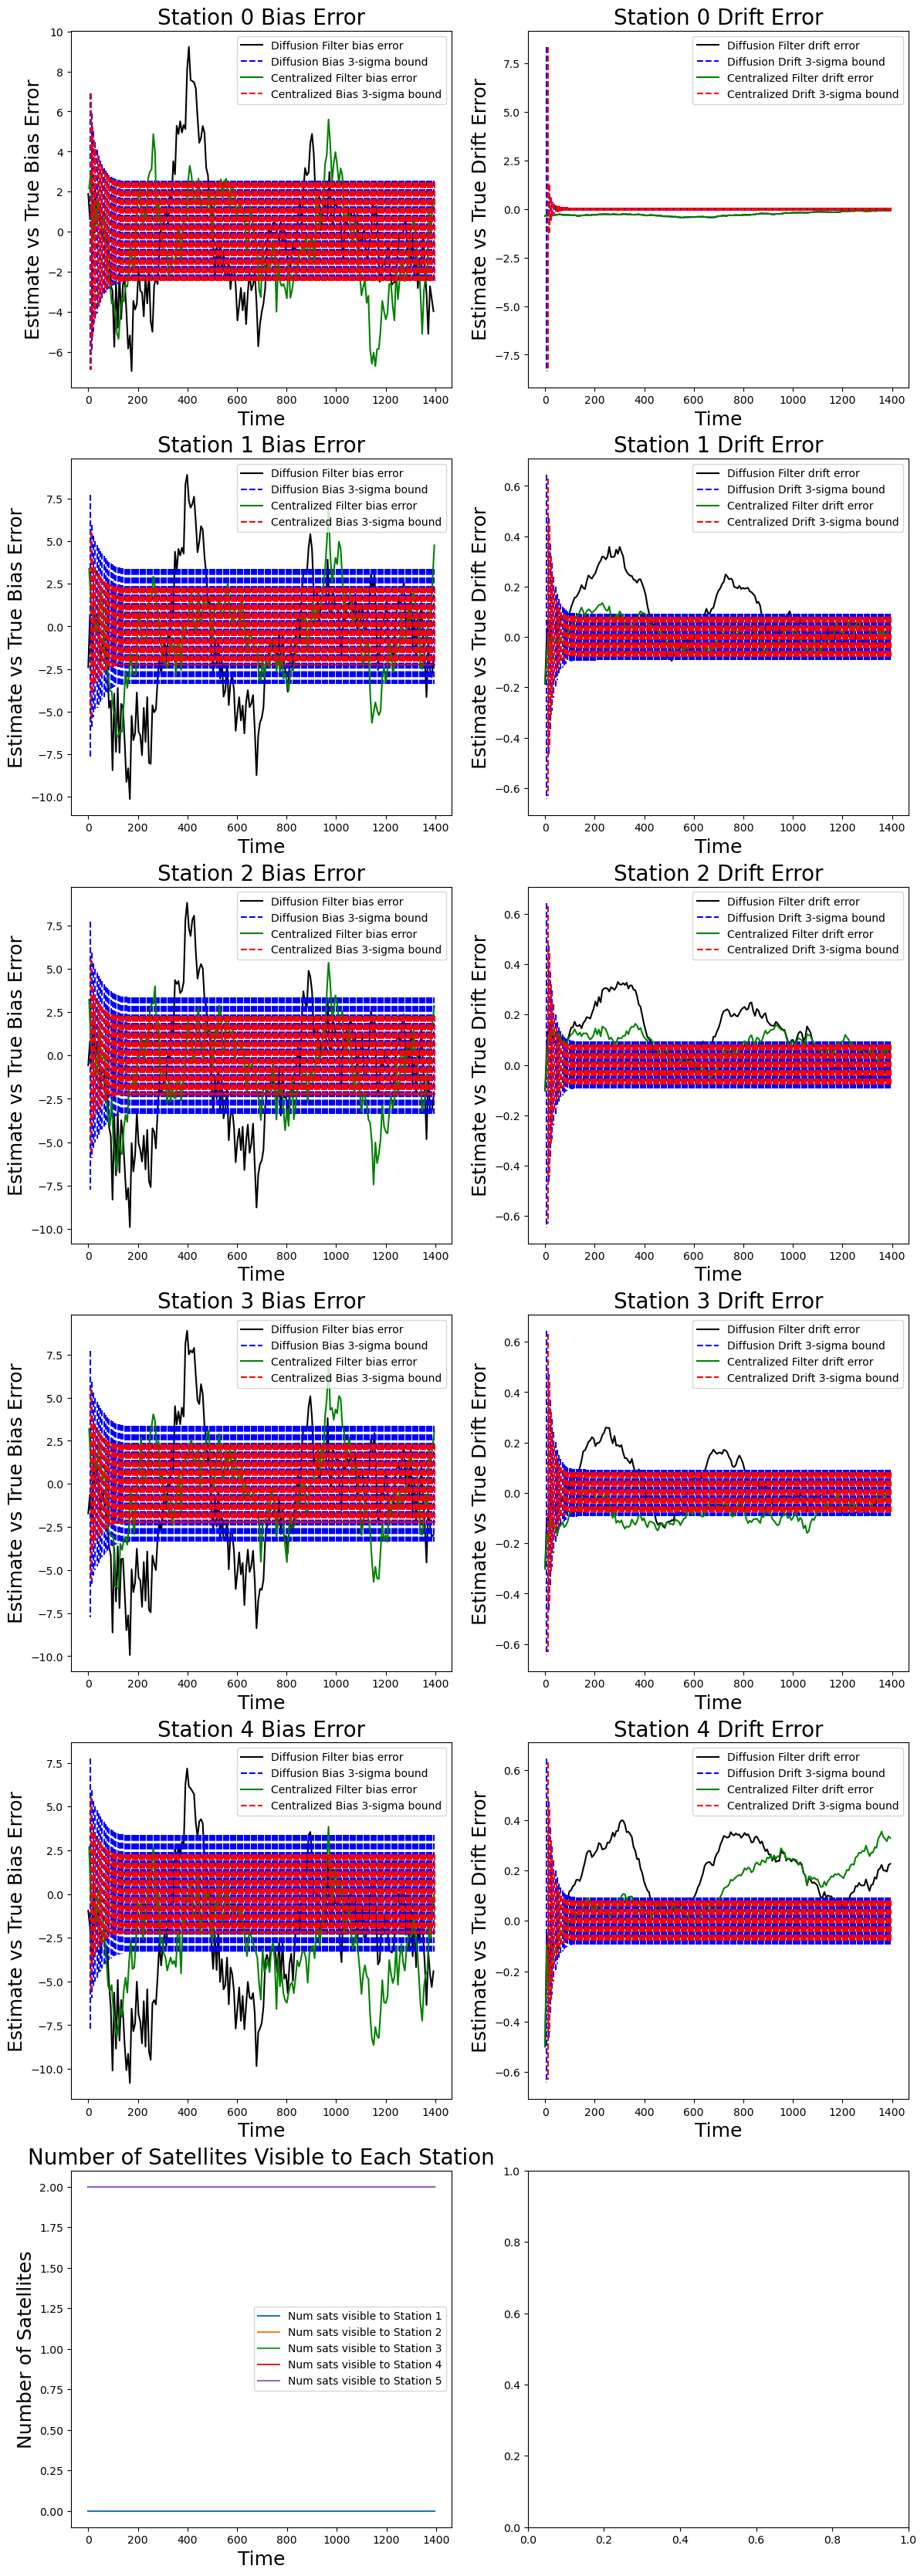

In [148]:
#Number of stations whose plots we are looking at
k = [0,1,2,3,4]

num_rows = len(k)
fig,axs = plt.subplots(num_rows+1,2, figsize=(14, 7*(num_rows+1)))
t_hist = np.arange(0, dt*iterations, dt)
t_hist_cf = np.arange(3.5, dt*iterations, dt)


for inx,i in enumerate(k):
    #Diffusion Filter Error Plots
    axs[inx][0].plot(t_hist, errors_df[:, i,0,0], 'k', label = "Diffusion Filter bias error")
    bias_cov = 3*np.sqrt(P_hist_df[:, i,0,0])
    axs[inx][0].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([bias_cov[1], -bias_cov[1]]), 'b--', label = "Diffusion Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([bias_cov[2:], -bias_cov[2:]]), 'b--')
    
    axs[inx][0].plot(t_hist_cf, errors_cf[:, i,0,0], 'g', label = "Centralized Filter bias error")
    bias_cov = 3*np.sqrt(P_hist_cf[:, i,0,0])
    axs[inx][0].plot(np.vstack([t_hist_cf[1], t_hist_cf[1]]), np.vstack([bias_cov[1], -bias_cov[1]]), 'r--', label = "Centralized Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist_cf[2:], t_hist_cf[2:]]), np.vstack([bias_cov[2:], -bias_cov[2:]]), 'r--')
    
    axs[inx][0].legend()
    axs[inx][0].set_title("Station "+str(i)+" Bias Error", fontsize = 20)
    axs[inx][0].set_xlabel("Time", fontsize = 18)
    axs[inx][0].set_ylabel("Estimate vs True Bias Error", fontsize = 18)

    axs[inx][1].plot(t_hist, errors_df[:, i,1,0], 'k', label = "Diffusion Filter drift error")
    drift_cov = 3*np.sqrt(P_hist_df[:, i,1,1])
    axs[inx][1].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([drift_cov[1], -drift_cov[1]]), 'b--', label = "Diffusion Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([drift_cov[2:], -drift_cov[2:]]), 'b--')
    
    axs[inx][1].plot(t_hist, errors_cf[:, i,1,0], 'g', label = "Centralized Filter drift error")
    drift_cov = 3*np.sqrt(P_hist_cf[:, i,1,1])
    axs[inx][1].plot(np.vstack([t_hist_cf[1], t_hist_cf[1]]), np.vstack([drift_cov[1], -drift_cov[1]]), 'r--', label = "Centralized Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist_cf[2:], t_hist_cf[2:]]), np.vstack([drift_cov[2:], -drift_cov[2:]]), 'r--')
    
    axs[inx][1].legend()
    axs[inx][1].set_title("Station "+str(i)+" Drift Error", fontsize = 20)
    axs[inx][1].set_xlabel("Time", fontsize = 18)
    axs[inx][1].set_ylabel("Estimate vs True Drift Error", fontsize = 18)
    
for i in range(n):
    axs[-1][0].plot(t_hist,num_msmts[:,i], label = f"Num sats visible to Station {i+1}")
    
axs[-1][0].legend()
axs[-1][0].set_title("Number of Satellites Visible to Each Station", fontsize = 20)
axs[-1][0].set_xlabel("Time", fontsize = 18)
axs[-1][0].set_ylabel("Number of Satellites", fontsize = 18)



plt.show()